# Split data into multiple rows with iterators

Transform a single document, video, image, or audio file into multiple rows for granular processing.

**What's in this recipe:**

- Split documents into text chunks for RAG
- Extract frames or segments from videos
- Tile images for high-resolution analysis
- Chunk audio files for transcription

## Problem

You have documents, videos, or text that you need to break into smaller pieces for processing. A PDF needs to be split into chunks for retrieval-augmented generation. A video needs individual frames for analysis. Text needs to be divided into sentences or sliding windows.

You need a way to transform one source row into multiple output rows automatically.

## Solution

You create views with iterator functions that split source data into multiple rows. Pixeltable provides built-in iterators for documents, videos, images, audio, and strings.

### Setup

In [1]:
%pip install -qU pixeltable

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pixeltable as pxt

### Split documents into chunks

Use `document_splitter` to break documents (PDF, HTML, Markdown, TXT) into text chunks.

In [3]:
from pixeltable.functions.document import document_splitter

pxt.drop_dir('iterator_demo', force=True)
pxt.create_dir('iterator_demo')

docs = pxt.create_table('iterator_demo.docs', {'doc': pxt.Document})
docs.insert([{'doc': 'https://raw.githubusercontent.com/pixeltable/pixeltable/main/docs/resources/rag-demo/Jefferson-Amazon.pdf'}])

Creating a Pixeltable instance at: /Users/pjlb/.pixeltable
Connected to Pixeltable database at: postgresql+psycopg://postgres:@/pixeltable?host=/Users/pjlb/.pixeltable/pgdata
Created directory 'iterator_demo'.
Created table 'docs'.
Inserting rows into `docs`: 1 rows [00:00, 206.70 rows/s]
Inserted 1 row with 0 errors.


1 row inserted, 2 values computed.

In [4]:
chunks = pxt.create_view(
    'iterator_demo.doc_chunks',
    docs,
    iterator=document_splitter(docs.doc, separators='sentence,token_limit', limit=300)
)
chunks.select(chunks.text).limit(3).collect()

  Using cached https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.8.0/en_core_web_sm-3.8.0-py3-none-any.whl (12.8 MB)


✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
Inserting rows into `doc_chunks`: 139 rows [00:00, 44127.18 rows/s]


text
FINANCIAL SONAR™: REALITY RADAR ON COMPANY PERFORMANCE NASDAQGSAMZN AMAZON.COM
INC. REGION NORTH AMERICA INDUSTRY INTERNET AND DIRECT MARKETING RETAIL SELL OVERALL RATING FOR 1ST QUARTER 2024 www.jeffersonresearch.com
"© 2024 Jefferson Research & Management Report prepared on June 21, 2024 OUR EVALUATION OF AMZN Amazon.com Inc. is showing strong Earnings Quality and Balance Sheet Quality, but Valuation suggests a higher amount of price risk, and Cash Flow Quality and Operating Efficiency are both weak."


**Available separators:**

- `heading` — Split on HTML/Markdown headings
- `sentence` — Split on sentence boundaries (requires spacy)
- `token_limit` — Split by token count (requires tiktoken)
- `char_limit` — Split by character count
- `page` — Split by page (PDF only)

### Extract frames from videos

Use `frame_iterator` to extract frames at specified intervals.

In [5]:
from pixeltable.functions.video import frame_iterator

videos = pxt.create_table('iterator_demo.videos', {'video': pxt.Video})
videos.insert([{'video': 'https://github.com/pixeltable/pixeltable/raw/main/docs/resources/bangkok.mp4'}])

Created table 'videos'.
Inserting rows into `videos`: 1 rows [00:00, 851.12 rows/s]
Inserted 1 row with 0 errors.


1 row inserted, 2 values computed.

Inserting rows into `frames`: 19 rows [00:00, 10514.81 rows/s]


frame_idx,pos_msec,frame
0,0.,
1,1000.,
2,2000.,

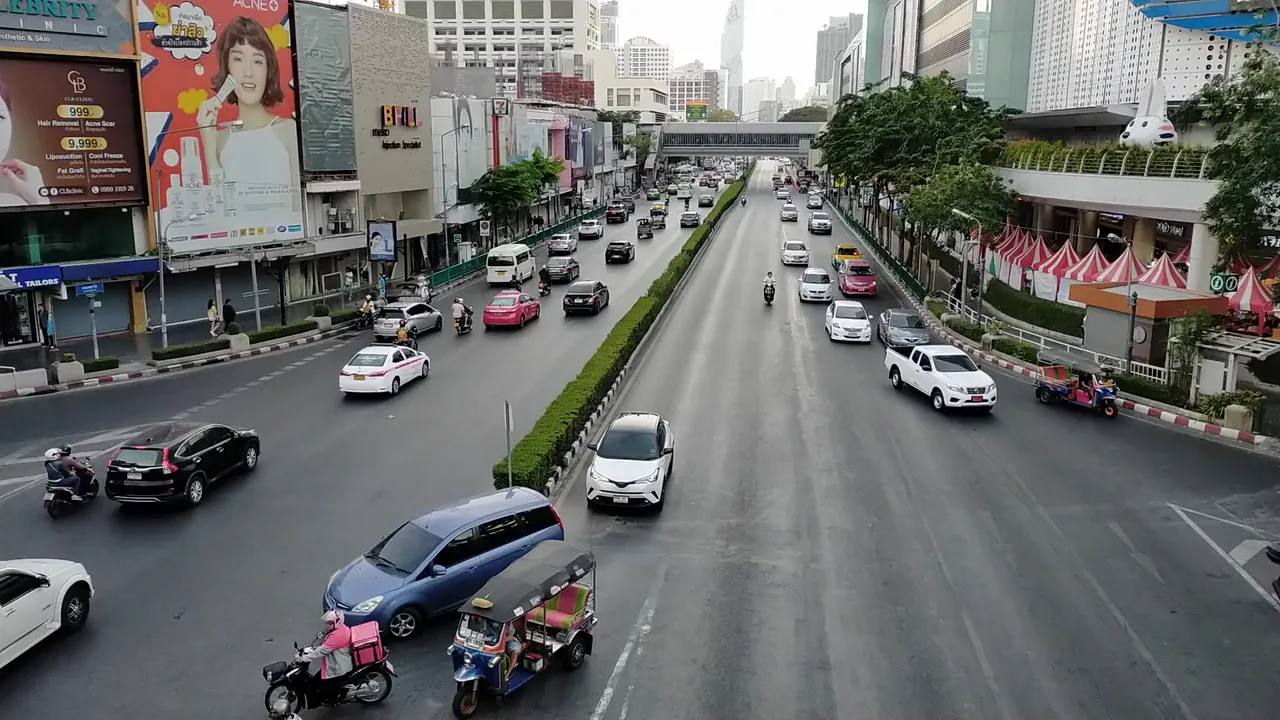
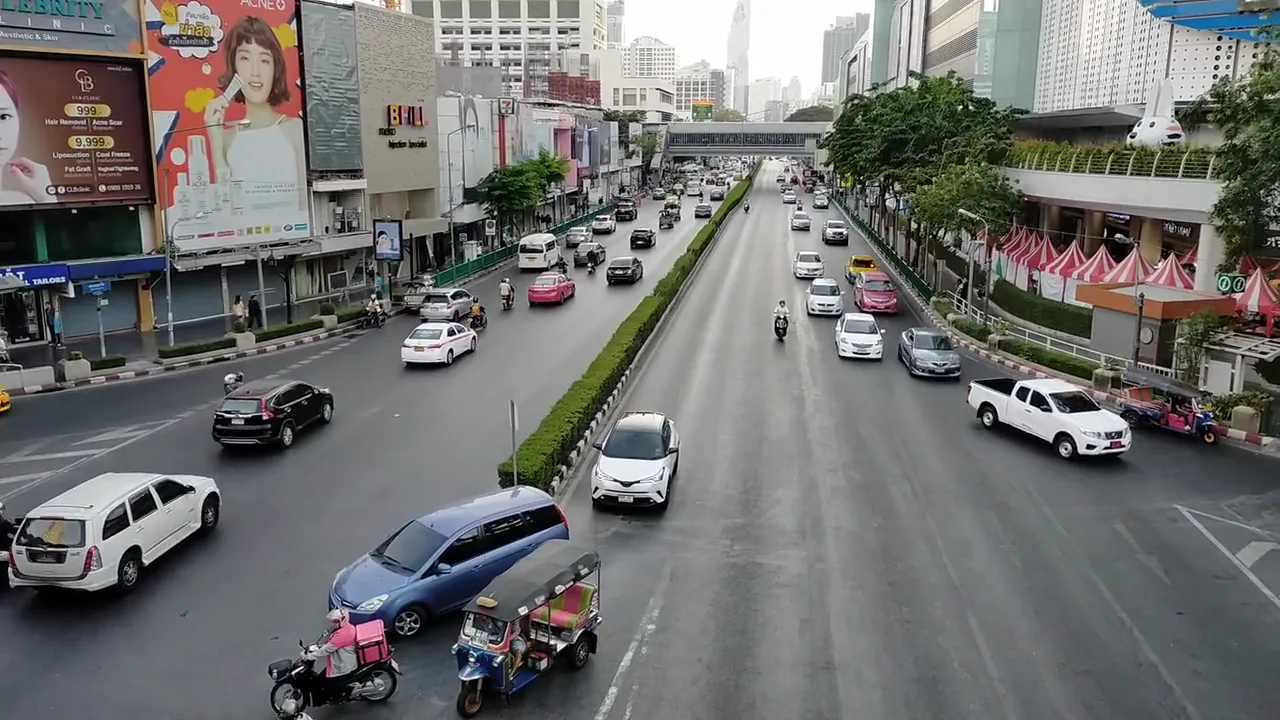
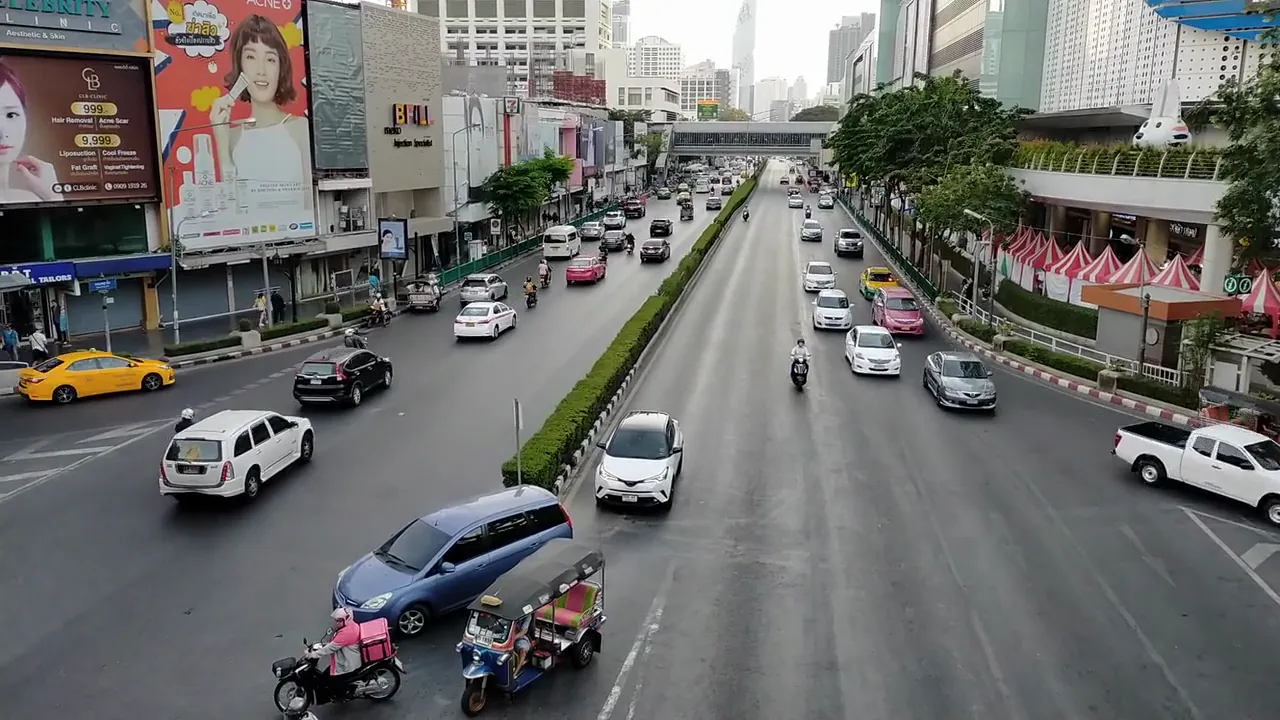

In [6]:
frames = pxt.create_view(
    'iterator_demo.frames',
    videos,
    iterator=frame_iterator(videos.video, fps=1.0)
)
frames.select(frames.frame_idx, frames.pos_msec, frames.frame).limit(3).collect()

**frame_iterator options:**

- `fps` — Frames per second to extract
- `num_frames` — Extract exact number of frames (evenly spaced)
- `keyframes_only` — Extract only keyframes

### Split videos into segments

Use `video_splitter` to divide videos into smaller clips.


In [ ]:
from pixeltable.functions.video import video_splitter

segments = pxt.create_view(
    'iterator_demo.segments',
    videos,
    iterator=video_splitter(videos.video, duration=5.0, min_segment_duration=1.0)
)
segments.select(segments.segment_start, segments.segment_end, segments.video_segment).limit(3).collect()


Inserting rows into `segments`: 4 rows [00:00, 1349.84 rows/s]


AttributeError: Unknown column: start_time

**video_splitter options:**

- `duration` — Duration of each segment in seconds
- `overlap` — Overlap between segments in seconds
- `min_segment_duration` — Drop last segment if shorter than this


### Split strings into sentences

Use `string_splitter` to divide text into sentences.

In [ ]:
from pixeltable.functions.string import string_splitter

texts = pxt.create_table('iterator_demo.texts', {'content': pxt.String})
texts.insert([{'content': 'AI data infrastructure simplifies ML workflows. Declarative pipelines update incrementally. This makes development faster and more maintainable.'}])

In [ ]:
sentences = pxt.create_view(
    'iterator_demo.sentences',
    texts,
    iterator=string_splitter(texts.content, separators='sentence')
)
sentences.select(sentences.text).collect()

### Tile images for analysis

Use `tile_iterator` to split large images into smaller tiles.

In [ ]:
from pixeltable.functions.image import tile_iterator

images = pxt.create_table('iterator_demo.images', {'image': pxt.Image})
images.insert([{'image': 'https://raw.githubusercontent.com/pixeltable/pixeltable/main/docs/resources/images/000000000030.jpg'}])

In [ ]:
tiles = pxt.create_view(
    'iterator_demo.tiles',
    images,
    iterator=tile_iterator(images.image, tile_size=(224, 224), overlap=(32, 32))
)
tiles.select(tiles.tile_idx, tiles.tile).limit(4).collect()


**tile_iterator options:**

- `tile_size` — Size of each tile as `(width, height)`
- `overlap` — Overlap between adjacent tiles as `(width, height)`


### Split audio into chunks

Use `audio_splitter` to divide audio files into time-based chunks for transcription or analysis.

In [ ]:
from pixeltable.functions.audio import audio_splitter

audio = pxt.create_table('iterator_demo.audio', {'audio': pxt.Audio})
audio.insert([{'audio': 'https://raw.githubusercontent.com/pixeltable/pixeltable/main/docs/resources/10-minute%20tour%20of%20Pixeltable.mp3'}])


In [ ]:
audio_chunks = pxt.create_view(
    'iterator_demo.audio_chunks',
    audio,
    iterator=audio_splitter(audio.audio, chunk_duration_sec=30.0, overlap_sec=2.0)
)
audio_chunks.select(audio_chunks.start_time_sec, audio_chunks.end_time_sec).limit(5).collect()


**audio_splitter options:**

- `chunk_duration_sec` — Duration of each chunk in seconds
- `overlap_sec` — Overlap between chunks in seconds
- `min_chunk_duration_sec` — Drop last chunk if shorter than this

## See also

- [Split documents for RAG](https://docs.pixeltable.com/howto/cookbooks/text/doc-chunk-for-rag)
- [Extract frames from videos](https://docs.pixeltable.com/howto/cookbooks/video/video-extract-frames)
- [Transcribe audio files](https://docs.pixeltable.com/howto/cookbooks/audio/audio-transcribe)